In [1]:
%env CUDA_VISIBLE_DEVICES=0
%matplotlib inline

env: CUDA_VISIBLE_DEVICES=0


In [2]:
import matplotlib
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import utils.plot_functions as pf
import numpy as np
from cae_model import cae
import time

In [3]:
params = {}
#shitty hard coding
params["n_mem"] = 32768  #32768 #49152 for color, 32768 for grayscale

#general params
params["run_name"] = "7680_med_compress_pcm"
params["file_location"] = "/media/tbell/datasets/natural_images.txt"
params["gpu_ids"] = ["0"]
params["output_location"] = os.path.expanduser("~")+"/CAE_Project/CAEs/model_outputs/"+params["run_name"]
params["num_threads"] = 6
params["num_epochs"] = 40
params["epoch_size"] = 112682
params["eval_interval"] = 100
params["seed"] = 1234567890

#checkpoint params
params["run_from_check"] = False
params["check_load_run_name"] = "train"
params["check_load_path"] = "/home/dpaiton/CAE_Project/CAEs/model_outputs/"+params["check_load_run_name"]+"/checkpoints/chkpt_-22800"

#image params
params["shuffle_inputs"] = True
params["batch_size"] = 100
params["img_shape_y"] = 256
params["num_colors"] = 1
params["downsample_images"] = True
params["downsample_method"] = "resize" # can be "crop" or "resize"

#learning rates
params["init_learning_rate"] = 5.0e-4
params["decay_steps"] = 10000#epoch_size*0.5*num_epochs #0.5*epoch_size
params["staircase"] = True
params["decay_rate"] = 0.9

#layer params
params["memristorify"] = False
params["god_damn_network"] = True
params["relu"] = False

#layer dimensions
params["input_channels"] = [params["num_colors"], 128, 128]
params["output_channels"] = [128, 128, 128]
params["patch_size_y"] = [9, 5, 5]
params["strides"] = [4, 2, 2]

#memristor params
params["GAMMA"] = 1.0  # slope of the out of bounds cost
params["mem_v_min"] = -1.0
params["mem_v_max"] = 1.0
params["gauss_chan"] = False

cae_model = cae(params)

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.allow_soft_placement = True
config.log_device_placement = False # for debugging - log devices used by each variable

with tf.Session(config=config, graph=cae_model.graph) as sess:
  sess.run(cae_model.init_op)
  if cae_model.params["run_from_check"] == True:
    cae_model.full_saver.restore(sess, cae_model.params["check_load_path"])
  # Coordinator manages threads, checks for stopping requests
  coord = tf.train.Coordinator()
  # queue_runners are created by helper functions tf.train.string_input_producer() and tf.train.batch_join()
  enqueue_threads = tf.train.start_queue_runners(sess, coord=coord, start=True)

  _, step, u_list = sess.run([cae_model.train_op, cae_model.global_step, cae_model.u_list])
  coord.request_stop()
  coord.join(enqueue_threads)

In [16]:
u_vals = u_list[int(params["num_layers"]/2)].reshape((100, 16*16*128))

In [5]:
def get_line_eq(x_points, y_points):
  m = (y_points[1]-y_points[0]) / (x_points[1]-x_points[0])
  b = y_points[1] - m * x_points[1]
  return (m, b)

In [6]:
def get_ms_and_bs(data):
  ms = []
  bs = []
  x0s = []
  x1s = []
  for xy_points in data:
    m,b = get_line_eq(xy_points[0], xy_points[1])
    ms.append(m)
    bs.append(b)
    x0s.append(xy_points[0][0])
    x1s.append(xy_points[0][1])
  return (ms, bs, x0s, x1s)

In [7]:
def get_differential_entropy(x_points, y_points, m, b):
  if m == 0:
    if b == 0:
      return 0
    else:
      return x_points[1]*-(b*np.log(b)) - x_points[0]*-(b*np.log(b)) #integral x_0, x_1 {-(mx+b)ln(mx+b)}, m=0
  else:
    if (m*x_points[0]+b <=0 or m*x_points[1]+b <=0): #weird edge case from area normalization (happens with few bins)
      return 0
    integral = lambda x, m, b: -(2*(m*x+b)**2 * np.log(m*x+b) - m*x*(m*x+2*b))/(4*m)
    return integral(x_points[1], m, b) - integral(x_points[0], m, b)

In [8]:
def compute_area(ms, bs, x0s, x1s):
  total_area = 0
  for m,b,x0,x1 in zip(ms,bs,x0s,x1s):
    unit_area = (m/2.0)*(x1**2-x0**2) + b*(x1-x0) #integral x_0, x_1 mx+b = m/2*x^2 + bx | x_0, x_1
    assert unit_area >=0, ("area must be greater than or equal to zero!")
    total_area += unit_area
  return total_area

In [9]:
def get_normalized_points(xy_points, area, m0, b0):
  x0 = xy_points[0][0]  
  x1 = xy_points[0][1]
  x_diff = x1-x0
  x_diff_sq = (x1**2-x0**2)
  new_b = ((m0/2.0*x_diff_sq + b0*x_diff)/(area*x_diff)) - ((m0/2.0)*x_diff_sq/x_diff)
  new_points = [[xy_points[0][0], xy_points[0][1]], [m0*xy_points[0][0]+new_b, m0*xy_points[0][1]+new_b]]
  return new_points

In [10]:
def unit_entropy(data, eps=None):
  ms, bs, x0s, x1s = get_ms_and_bs(data)
  area = compute_area(ms, bs, x0s, x1s)
  new_data = []
  for idx, xy_points in enumerate(data):
    m0 = ms[idx]
    b0 = bs[idx]
    xy_points = get_normalized_points(xy_points, area, m0, b0)
    new_data.append(xy_points)
  ms, bs, x0s, x1s = get_ms_and_bs(new_data)
    
  entropy = 0
  for idx, xy_points in enumerate(new_data):
    m = ms[idx]
    b = bs[idx]
    if (xy_points[1][0] == xy_points[1][1] and xy_points[1][1] == 0):
      entropy += 0
    else:
      if eps is not None:
        if xy_points[1][0] == 0:
          xy_points[1][0] += eps
        if xy_points[1][1] == 0:
          xy_points[1][1] += eps
      entropy += get_differential_entropy(xy_points[0], xy_points[1], m, b)
  return entropy

In [11]:
def var(xs,ys):
    mean_xs = (np.dot(xs,ys))/np.size(xs)
    norm_mean = np.square(xs-mean_xs)
    var_xs = (np.dot(norm_mean,ys))
    return var_xs

In [12]:
def hist_ent(hist):
    hist_nz_idx = [hist!=0]
    hist_nz = hist[hist_nz_idx]
    surprise=(-1)*np.log(hist_nz)
    ent = np.dot(hist_nz,surprise)
    return ent

In [13]:
def plot_hists(u_val_list, num_plots, num_bins):
    fig, ax = plt.subplots(num_plots,2, figsize=(20, 5*num_plots))
    for plot in range(num_plots):
        u_val = u_val_list[plot]

        hist, bin_edges = np.histogram(u_val, bins=num_bins)
        hist = hist/np.sum(hist)
        bin_edges = bin_edges[:-1]

        var_xs = var(bin_edges,hist)
        #print("var_xs: ", var_xs)
        gauss_ent = 0.5*np.log(2*np.pi*np.e*var_xs)
        disc_ent = hist_ent(hist)

        ax[plot, 0].bar(bin_edges, hist, edgecolor="k", width=0.05)
        ax[plot, 0].set_xlim((min(bin_edges), max(bin_edges)))
        ax[plot, 0].set_title("Entropy="+str(round(disc_ent,2)), fontsize=18)

        ax[plot, 1].scatter(bin_edges, hist)
        hist_data = []
        for index in np.arange(len(hist[:-1])):
          x_points = [bin_edges[index], bin_edges[index+1]]
          y_points = [hist[index], hist[index+1]]
          #print(y_points)
          hist_data.append((x_points, y_points))
          ax[plot, 1].plot(x_points, y_points, linewidth=2, color="k")
        t0 = time.time()
        entropy = unit_entropy(hist_data, eps=1e-12)
        t1 = time.time()
        print("unit_entropy: ",(t1-t0))
        ax[plot, 1].set_title("Entropy="+str(round(entropy,2))+", Gauss Entropy="+str(round(gauss_ent,2)), fontsize=18)
        ylim = ax[plot, 1].get_ylim()
        ax[plot, 1].set_ylim((0, ylim[1]))
    plt.show()

In [ ]:
t0 = time.time()
num_plots = 3
num_bins = 50
gauss_test = [np.random.normal(0, 3, 10000) for idx in range(num_plots)]
plot_hists(gauss_test, num_plots, num_bins)
t1 = time.time()
total_time = t1-t0
print (total_time)

In [17]:
print(u_vals.shape)

(100, 32768)


unit_entropy:  0.0009982585906982422
unit_entropy:  0.0011439323425292969
unit_entropy:  0.001178741455078125


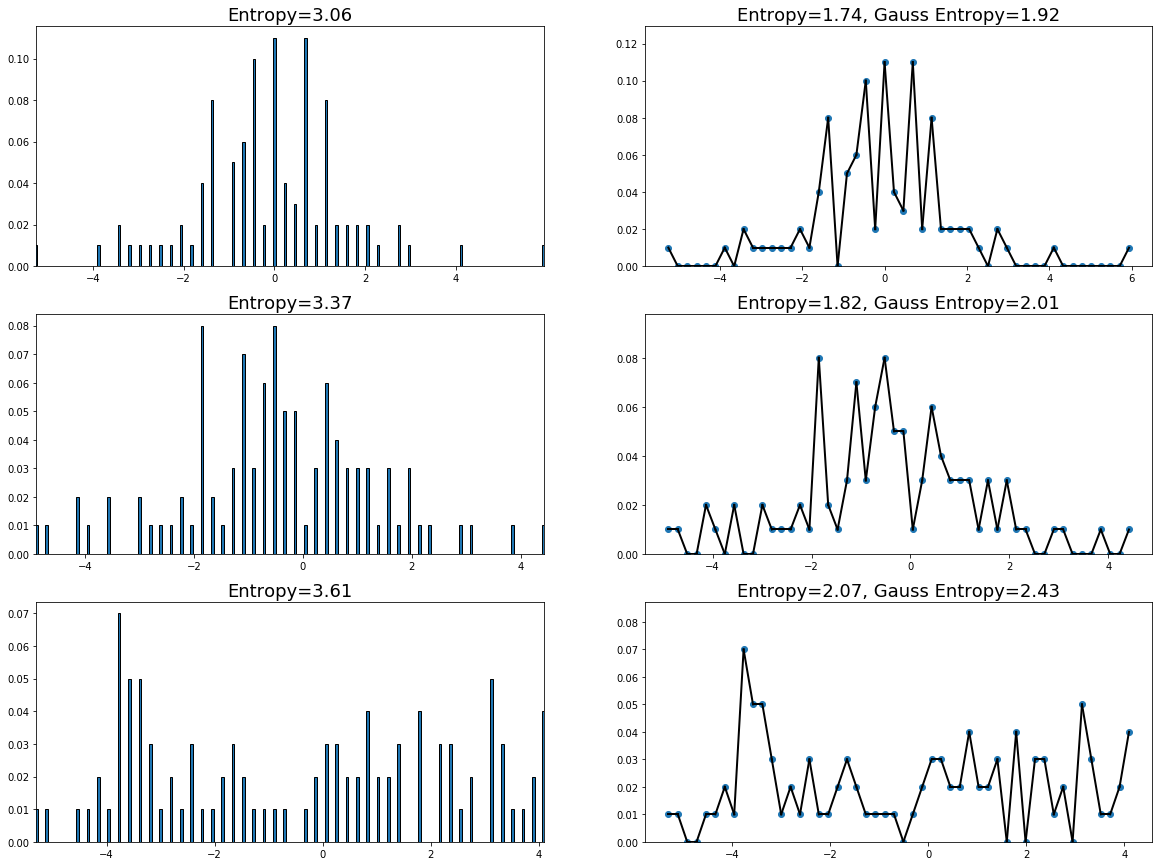

In [18]:
num_plots = 3
num_bins = 50
u_val_list = [u_vals[:, rnd_unit] for rnd_unit in np.random.choice(16*16*128, num_plots)]
plot_hists(u_val_list, num_plots, num_bins)

In [ ]:
sample_indices = np.random.choice(np.arange(len(u_vals)), 10)
sample_activations = u_val[sample_indices]
print(u_val[sample_indices])

eps = 1e-2

count = lambda x,y,z: np.sum(np.int32((x<y+z) & (x>y-z)))

counts = [count(u_val, u_val[samp], eps) for samp in sample_indices]
print(counts)

fig, ax = plt.subplots(1, figsize=(10,10))
ax.bar(sample_activations, counts, edgecolor="k", width=0.05)
ax.set_xlim((min(bin_edges), max(bin_edges)))
plt.show()